In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
import pandas as pd
from collections import defaultdict
import random
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (15, 8)
sns.set_style("whitegrid")

## Basic loading and exploration
- Trying to understand structure/context

In [2]:
def load_data_info(data_dir: str = "data") -> Dict:    
    positive_dir = Path.cwd().parent / data_dir / "image_pairs_positives"
    negative_dir = Path.cwd().parent / data_dir / "image_pairs_negatives"
    
    info = {
        'positive_pairs': 0,
        'negative_pairs': 0,
        'positive_folders': [],
        'negative_folders': [],
        'positive_images': [],
        'negative_images': []
    }
    
    positive_folders = [f for f in positive_dir.iterdir() if f.is_dir()]
    info['positive_pairs'] = len(positive_folders)
    info['positive_folders'] = positive_folders
    
    for folder in positive_folders:
        images = list(folder.glob("*.webp"))
        if len(images) >= 2:
            info['positive_images'].append((images[0], images[1]))

    negative_folders = [f for f in negative_dir.iterdir() if f.is_dir()]
    info['negative_pairs'] = len(negative_folders)
    info['negative_folders'] = negative_folders
    
    for folder in negative_folders:
        images = list(folder.glob("*.webp"))
        if len(images) >= 2:
            info['negative_images'].append((images[0], images[1]))
        
    return info

def display_dataset_overview(info: Dict):    
    print("DATASET OVERVIEW")
    print("=" * 50)
    print(f"Positive pairs (same mother): {info['positive_pairs']}")
    print(f"Negative pairs (different mothers): {info['negative_pairs']}")

def load_image_pair(folder_path: Path) -> Tuple[np.ndarray, np.ndarray]:    
    images = list(folder_path.glob("*.webp"))
    if len(images) != 2:
        raise ValueError(f"Expected 2 images in {folder_path}, found {len(images)}")
    
    img1 = np.array(Image.open(images[0]))
    img2 = np.array(Image.open(images[1]))
    
    return img1, img2

def analyze_image_properties(data_dir: str = "data", sample_size: int = 20) -> Dict:    
    positive_dir = Path(data_dir) / "image_pairs_positives"
    negative_dir = Path(data_dir) / "image_pairs_negatives"
    
    properties = {
        'resolutions': [],
        'file_sizes': [],
        'channels': [],
        'mean_colors': [],
        'std_colors': [],
        'pair_types': []
    }
    
    pos_folders = list(positive_dir.iterdir())[:sample_size//2] if positive_dir.exists() else []
    neg_folders = list(negative_dir.iterdir())[:sample_size//2] if negative_dir.exists() else []
    
    for folder, pair_type in [(f, 'positive') for f in pos_folders] + [(f, 'negative') for f in neg_folders]:
        img1, img2 = load_image_pair(folder)
        
        for img in [img1, img2]:
            properties['resolutions'].append(f"{img.shape[1]}x{img.shape[0]}")
            properties['channels'].append(img.shape[2] if len(img.shape) == 3 else 1)
            properties['mean_colors'].append(np.mean(img, axis=(0, 1)) if len(img.shape) == 3 else np.mean(img))
            properties['std_colors'].append(np.std(img, axis=(0, 1)) if len(img.shape) == 3 else np.std(img))
            properties['pair_types'].append(pair_type)
    
    return properties

def display_image_properties(properties: Dict):    
    print("\nIMAGE PROPERTIES ANALYSIS")
    print("=" * 50)
    
    resolution_counts = pd.Series(properties['resolutions']).value_counts()
    print("Image Resolutions:")
    print(resolution_counts.head())
    
    channel_counts = pd.Series(properties['channels']).value_counts()
    print(f"\nColor Channels:")
    print(channel_counts)
    
    if properties['mean_colors']:
        mean_colors = np.array(properties['mean_colors'])
        print(f"\nColor Statistics (RGB):")
        print(f"Mean RGB: R={np.mean(mean_colors[:, 0]):.1f}, G={np.mean(mean_colors[:, 1]):.1f}, B={np.mean(mean_colors[:, 2]):.1f}")

def visualize_sample_pairs(info: Dict, n_samples: int = 3):    
    fig, axes = plt.subplots(2, n_samples * 2, figsize=(20, 8))
    fig.suptitle("Sample Image Pairs: Positive (Same Mother) vs Negative (Different Mothers)", fontsize=16)
    
    random_positive_pairs = random.sample(info['positive_images'], min(n_samples, len(info['positive_images'])))
    for i, (img1_path, img2_path) in enumerate(random_positive_pairs):
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)
        
        axes[0, i*2].imshow(img1)
        axes[0, i*2].set_title(f"Positive Pair {i+1} - Image 1", fontsize=10)
        axes[0, i*2].axis('off')
        
        axes[0, i*2+1].imshow(img2)
        axes[0, i*2+1].set_title(f"Positive Pair {i+1} - Image 2", fontsize=10)
        axes[0, i*2+1].axis('off')
    
    random_negative_pairs = random.sample(info['negative_images'], min(n_samples, len(info['negative_images'])))
    for i, (img1_path, img2_path) in enumerate(random_negative_pairs):
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)
        
        axes[1, i*2].imshow(img1)
        axes[1, i*2].set_title(f"Negative Pair {i+1} - Image 1", fontsize=10)
        axes[1, i*2].axis('off')
        
        axes[1, i*2+1].imshow(img2)
        axes[1, i*2+1].set_title(f"Negative Pair {i+1} - Image 2", fontsize=10)
        axes[1, i*2+1].axis('off')
    
    plt.tight_layout()
    plt.show()

def run_exploration(data_dir: str = "data"):    
    print("STARTING BOOK COVER DATA EXPLORATION")
    print("=" * 60)
    
    print("\nLoading dataset information...")
    info = load_data_info(data_dir)
    display_dataset_overview(info)
    
    print("\nAnalyzing image properties...")
    properties = analyze_image_properties(data_dir, sample_size=50)
    display_image_properties(properties)
    
    print("\nVisualizing sample pairs...")
    visualize_sample_pairs(info, n_samples=3)

    print("\nVisualizing more sample pairs...")
    visualize_sample_pairs(info, n_samples=3)

    print("\nVisualizing even more sample pairs...")
    visualize_sample_pairs(info, n_samples=3)

    print("\nEXPLORATION COMPLETE!")
    print("=" * 60)
    
    return info, properties

STARTING BOOK COVER DATA EXPLORATION

Loading dataset information...
DATASET OVERVIEW
Positive pairs (same mother): 500
Negative pairs (different mothers): 500

Analyzing image properties...

IMAGE PROPERTIES ANALYSIS
Image Resolutions:
Series([], Name: count, dtype: int64)

Color Channels:
Series([], Name: count, dtype: int64)

Visualizing sample pairs...


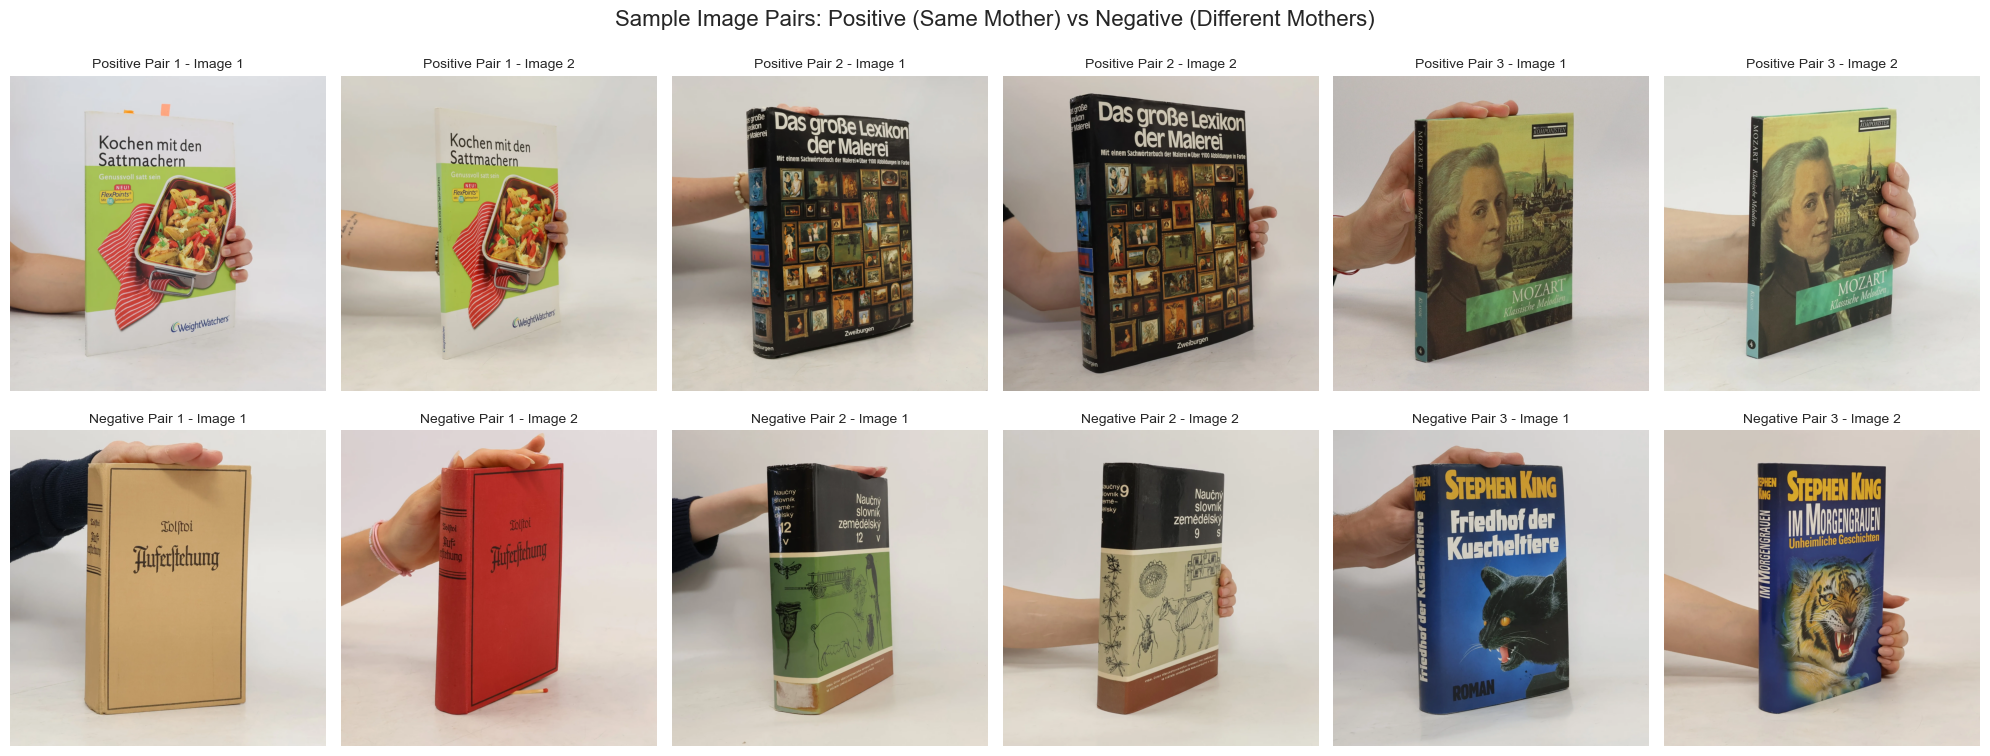


Visualizing more sample pairs...


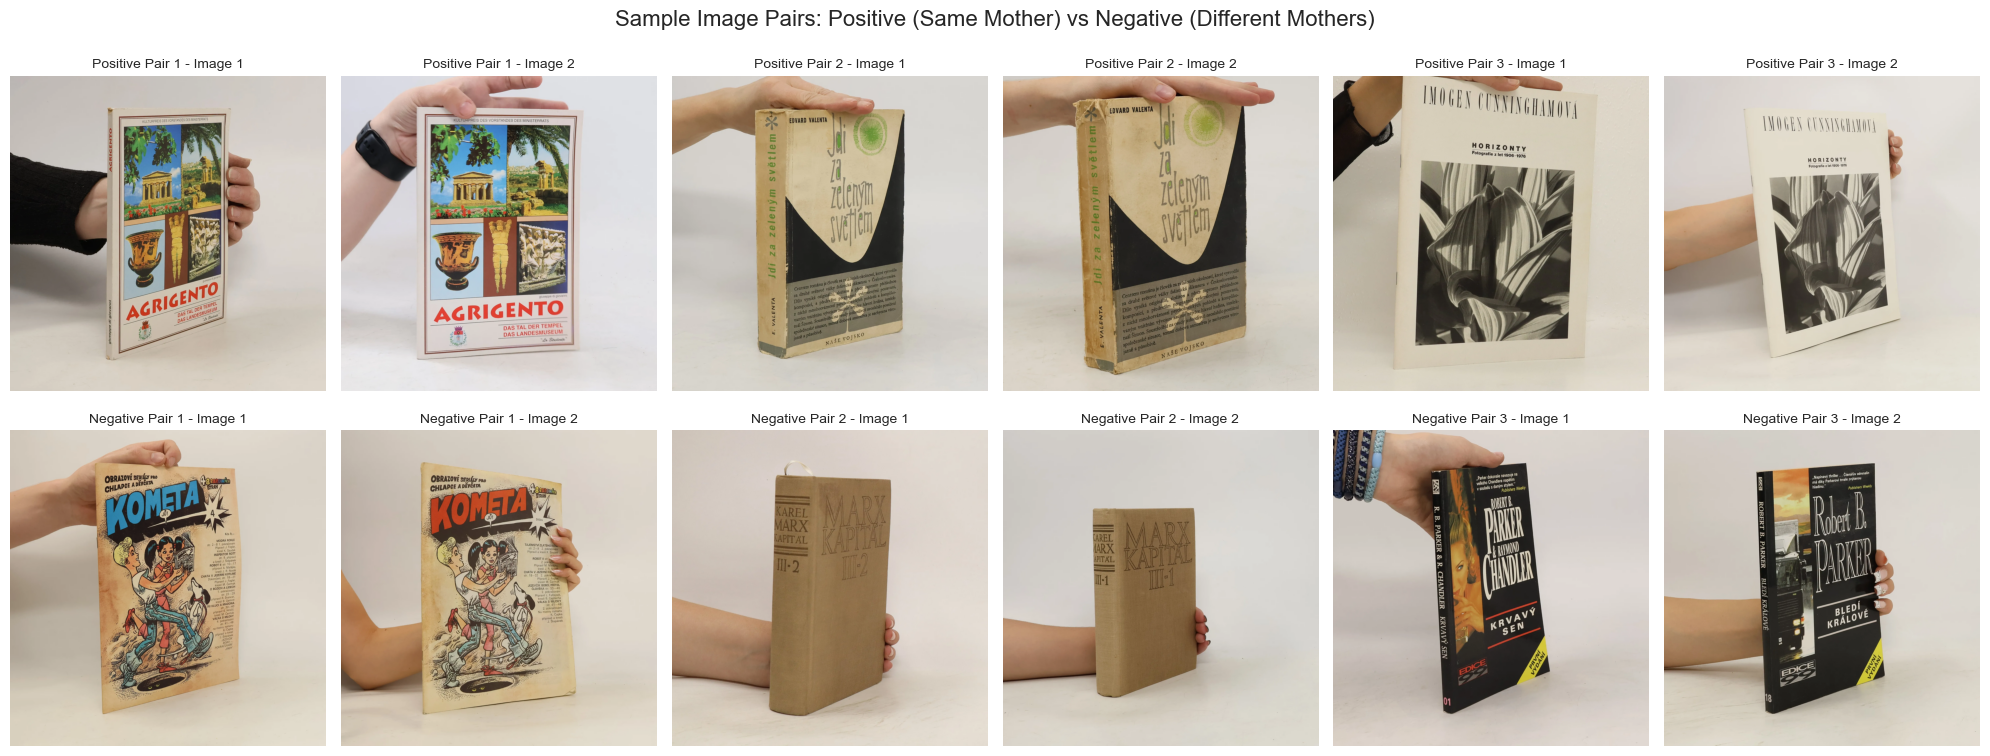


Visualizing even more sample pairs...


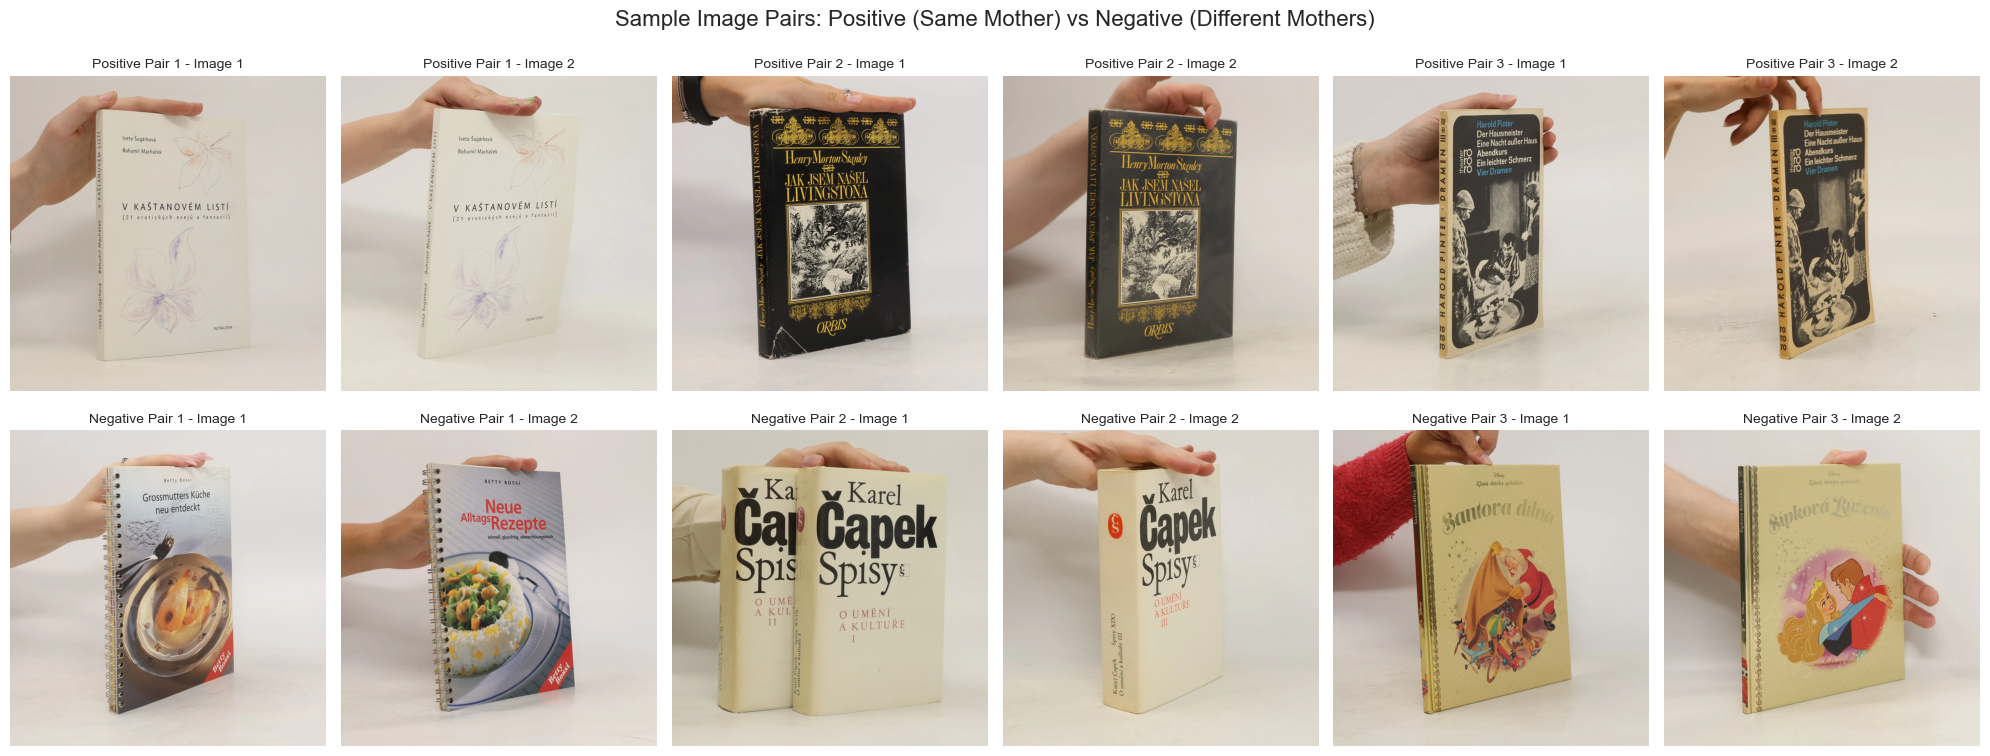


EXPLORATION COMPLETE!


In [3]:
info, properties = run_exploration("data")

- Images are standard size and color scheme
- Photos are hand-made, with varying hand and book positions
- Lighting looks fairly similar in each photo
- Positive images have the exact same cover and look identical (could have different wear and tear though)
- Negative images often have completely different covers, are a different part/sequel, or differ in if they are a part of a set

## Testing methods

### 1. Color similarity
- Very simple baseline to see if we could discriminate based on pixels, which are compared as binned histograms

In [172]:
def compare_color_similarity(info: Dict, n_samples: int = 20, bins: int = 32) -> Dict:
    similarities = {
        'positive': [],
        'negative': []
    }
    
    pos_pairs = random.sample(info['positive_images'], min(n_samples, len(info['positive_images'])))
    neg_pairs = random.sample(info['negative_images'], min(n_samples, len(info['negative_images'])))
    
    for pairs, label in [(pos_pairs, 'positive'), (neg_pairs, 'negative')]:
        for img1_path, img2_path in pairs:
            img1 = cv2.imread(str(img1_path))
            img2 = cv2.imread(str(img2_path))
            
            hsv1 = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
            hsv2 = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)
            
            hist1 = cv2.calcHist([hsv1], [0, 1, 2], None, [bins, bins, bins], [0, 180, 0, 256, 0, 256])
            hist2 = cv2.calcHist([hsv2], [0, 1, 2], None, [bins, bins, bins], [0, 180, 0, 256, 0, 256])
            
            cv2.normalize(hist1, hist1)
            cv2.normalize(hist2, hist2)
            
            sim = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
            similarities[label].append(sim)
    
    return similarities

def display_color_similarity_stats(similarities: Dict):
    print("\nCOLOR SIMILARITY ANALYSIS (HSV Histograms)")
    print("=" * 60)
    
    for label in ["positive", "negative"]:
        sims = similarities[label]
        if sims:
            print(f"{label.capitalize()} pairs: {len(sims)} samples")
            print(f"  Mean: {np.mean(sims):.3f}")

In [173]:
similarities = compare_color_similarity(info, n_samples=100, bins=32)
display_color_similarity_stats(similarities)


COLOR SIMILARITY ANALYSIS (HSV Histograms)
Positive pairs: 100 samples
  Mean: 0.234
Negative pairs: 100 samples
  Mean: 0.224


In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_classifier(classifier, info: Dict, n_samples: int = 100, bins = 8, resize_dim: Tuple[int,int]=(256,256), threshold: float = None, max_features: int = 500, metric='cosine'):
    similarities = classifier(info, n_samples=n_samples, bins=bins)
    
    scores = similarities['positive'] + similarities['negative']
    labels = [1] * len(similarities['positive']) + [0] * len(similarities['negative']) # 1=positive, 0=negative
    
    if threshold is None:
        mean_pos = np.mean(similarities['positive'])
        mean_neg = np.mean(similarities['negative'])
        threshold = (mean_pos + mean_neg) / 2.0
    
    preds = [1 if s >= threshold else 0 for s in scores]
    
    results = {
        "threshold": threshold,
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, zero_division=0),
        "recall": recall_score(labels, preds, zero_division=0),
        "f1": f1_score(labels, preds, zero_division=0)
    }
    
    return results

In [174]:
results_csim = evaluate_classifier(compare_color_similarity, info, n_samples=200, bins=8)
for k, v in results_csim.items():
    print(f"{k}: {v:.3f}" if isinstance(v, float) else f"{k}: {v}")

threshold: 0.706
accuracy: 0.545
precision: 0.537
recall: 0.655
f1: 0.590


- From the sample, positive pairs had very similar color similarities to negative pairs, so unlikely to be the way
- We need a lot of colors/bins to notice smaller differences + this would also fail completely given different lighting conditions or hand positions etc.

### 2. Structural similarity
- Slightly more advanced method, using contrasts, correlations etc. for patches of images

In [80]:
from skimage.metrics import structural_similarity as ssim

def compare_ssim(info: Dict, n_samples: int = 20, bins = 8, resize_dim: Tuple[int,int]=(256,256)) -> Dict:
    similarities = {'positive': [], 'negative': []}
    
    pos_pairs = random.sample(info['positive_images'], min(n_samples, len(info['positive_images'])))
    neg_pairs = random.sample(info['negative_images'], min(n_samples, len(info['negative_images'])))
    
    for pairs, label in [(pos_pairs, 'positive'), (neg_pairs, 'negative')]:
        for img1_path, img2_path in pairs:
            img1 = cv2.imread(str(img1_path), cv2.IMREAD_GRAYSCALE)
            img2 = cv2.imread(str(img2_path), cv2.IMREAD_GRAYSCALE)
            
            img1 = cv2.resize(img1, resize_dim)
            img2 = cv2.resize(img2, resize_dim)
            
            score = ssim(img1, img2)
            similarities[label].append(score)
    
    return similarities

results_ssim = evaluate_classifier(compare_ssim, info, n_samples=200, resize_dim=(256,256))
for k, v in results_ssim.items():
    print(f"{k}: {v:.3f}" if isinstance(v, float) else f"{k}: {v}")

threshold: 0.597
accuracy: 0.605
precision: 0.608
recall: 0.590
f1: 0.599


- Slightly better, but cannot capture the nuances of why books are different (different series, text...)

### 3. ORB
- ORB extracts keypoints (corners, conrasting pixels etc.) and rotates for invariability for each image (other similar techniques exist)
- These keypoint areas are then compared across the pair (Hamming distance - count of differing bits)

In [176]:
def compare_orb(info: Dict, n_samples: int = 20, bins = 8, max_features: int = 500) -> Dict:
    similarities = {'positive': [], 'negative': []}
    
    orb = cv2.ORB_create(nfeatures=max_features)
    
    pos_pairs = random.sample(info['positive_images'], min(n_samples, len(info['positive_images'])))
    neg_pairs = random.sample(info['negative_images'], min(n_samples, len(info['negative_images'])))
    
    for pairs, label in [(pos_pairs, 'positive'), (neg_pairs, 'negative')]:
        for img1_path, img2_path in pairs:
            img1 = cv2.imread(str(img1_path), cv2.IMREAD_GRAYSCALE)
            img2 = cv2.imread(str(img2_path), cv2.IMREAD_GRAYSCALE)
            
            kp1, des1 = orb.detectAndCompute(img1, None)
            kp2, des2 = orb.detectAndCompute(img2, None)
            
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            matches = bf.match(des1, des2)
            matches = sorted(matches, key=lambda x: x.distance)
            score = len(matches) / max(len(kp1), len(kp2))
            similarities[label].append(score)
    
    return similarities

results_orb = evaluate_classifier(compare_orb, info, n_samples=200, max_features=1000)
for k, v in results_orb.items():
    print(f"{k}: {v:.3f}" if isinstance(v, float) else f"{k}: {v}")

threshold: 0.356
accuracy: 0.730
precision: 0.750
recall: 0.690
f1: 0.719


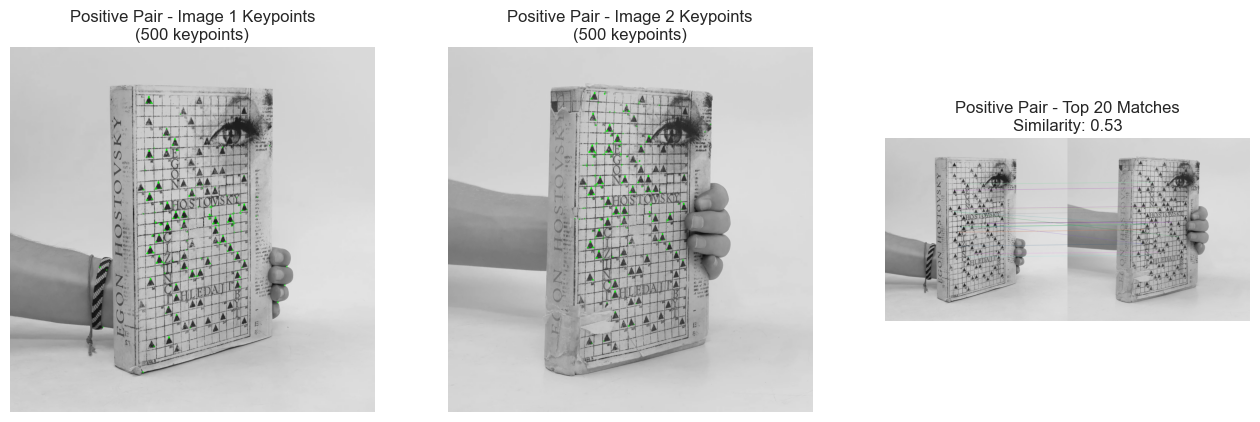

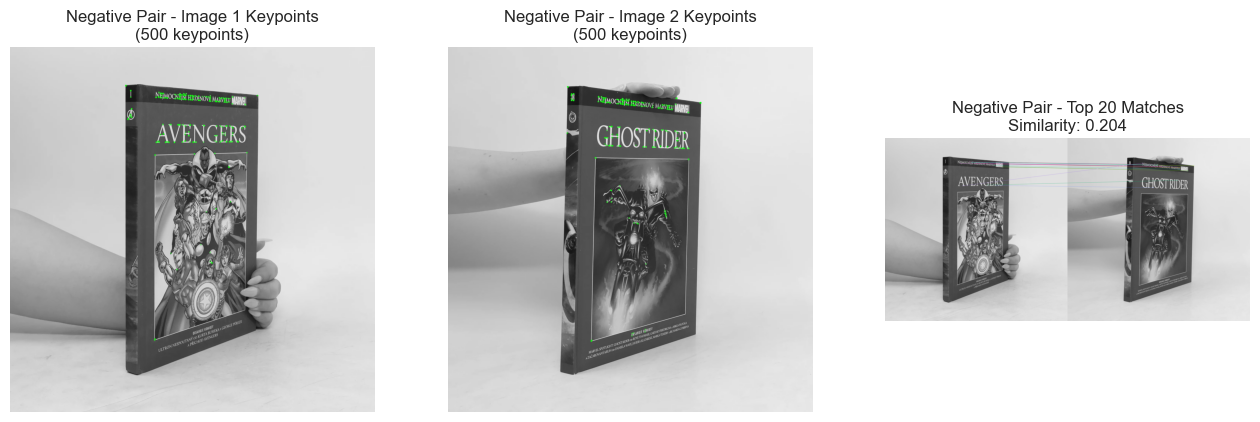

In [98]:
def visualize_orb_example(info: Dict):
    orb = cv2.ORB_create(nfeatures=500)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    pos_pair = random.choice(info['positive_images'])
    neg_pair = random.choice(info['negative_images'])
    
    for pair, title in [(pos_pair, "Positive Pair"), (neg_pair, "Negative Pair")]:
        img1_path, img2_path = pair
        img1 = cv2.imread(str(img1_path), cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(str(img2_path), cv2.IMREAD_GRAYSCALE)
        
        kp1, des1 = orb.detectAndCompute(img1, None)
        kp2, des2 = orb.detectAndCompute(img2, None)
        
        if des1 is not None and des2 is not None and len(des1) > 0 and len(des2) > 0:
            matches = bf.match(des1, des2)
            if len(matches) > 0:
                distances = [m.distance for m in matches]
                max_possible_distance = 64
                normalized_similarity = 1 - (sum(distances) / len(distances)) / max_possible_distance
                similarity_score = round(normalized_similarity, 3)
            else:
                similarity_score = 0.0
        else:
            similarity_score = 0.0
        
        img1_kp = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
        img2_kp = cv2.drawKeypoints(img2, kp2, None, color=(0,255,0), flags=0)
        
        matches = bf.match(des1, des2)
        matches = sorted(matches, key=lambda x: x.distance)
        img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None, flags=2)
        
        plt.figure(figsize=(16,6))
        plt.subplot(1,3,1)
        plt.imshow(img1_kp, cmap='gray')
        plt.title(f"{title} - Image 1 Keypoints\n({len(kp1)} keypoints)")
        plt.axis('off')
        
        plt.subplot(1,3,2)
        plt.imshow(img2_kp, cmap='gray')
        plt.title(f"{title} - Image 2 Keypoints\n({len(kp2)} keypoints)")
        plt.axis('off')
        
        plt.subplot(1,3,3)
        plt.imshow(img_matches)
        plt.title(f"{title} - Top 20 Matches\nSimilarity: {similarity_score}")
        plt.axis('off')
        plt.show()

visualize_orb_example(info)

- This method implicitly captures features like text and is robust to rotation
- Still a fairly lightweight method that does not have enough information for all comparisons
- Tried increasing number of features, but not much extra added value
- Also tried SIFT/AKAZE but these were just slower at not much extra added value

### 4. Pre-trained CNN
- Using large image networks promises deep embeddings from the layer just before classification, which can be then compared using e.g. cosine similarity

In [105]:
import torch
import torchvision.transforms as T
from torchvision.models import resnet50
import torch.nn.functional as F

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet50(weights='IMAGENET1K_V1')
resnet = resnet.eval().to(device)
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])

def get_embedding(image_path: str):
    img = Image.open(image_path).convert('RGB')
    x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = feature_extractor(x).squeeze()
        feat = F.normalize(feat, dim=0)
    return feat.cpu().numpy()

def compare_cnn_similarity(info: Dict, n_samples: int = 20, metric: str = "cosine", bins = 8) -> Dict:
    similarities = {'positive': [], 'negative': []}
    
    pos_pairs = random.sample(info['positive_images'], min(n_samples, len(info['positive_images'])))
    neg_pairs = random.sample(info['negative_images'], min(n_samples, len(info['negative_images'])))
    
    for pairs, label in [(pos_pairs, 'positive'), (neg_pairs, 'negative')]:
        for img1_path, img2_path in pairs:
            emb1 = get_embedding(img1_path)
            emb2 = get_embedding(img2_path)
            
            if metric == "cosine":
                sim = np.dot(emb1, emb2)
            elif metric == "euclidean":
                sim = -np.linalg.norm(emb1 - emb2)
            else:
                raise ValueError("metric must be 'cosine' or 'euclidean'")
            
            similarities[label].append(sim)
    
    return similarities

In [106]:
results_cnn = evaluate_classifier(compare_cnn_similarity, info, n_samples=100, metric="cosine")
for k, v in results_cnn.items():
    print(f"{k}: {v:.3f}" if isinstance(v, float) else f"{k}: {v}")

threshold: 0.901
accuracy: 0.780
precision: 0.746
recall: 0.850
f1: 0.794


- Now we are reaching decent accuracies, but hard to fine-tune since pre-trained
- Bigger models would probably improve this further, and we could tune the threshold for more precision

### 5. Image LLM
- The latest LLMs contain image capabilities from architectures like vision transformers, which can do zero-shot classification

In [ ]:
pip install google-generativeai

In [7]:
import google.generativeai as genai
genai.configure(api_key='insert_key')
model = genai.GenerativeModel('gemini-1.5-pro') # More lightweight model for now

def gemini_classifier(info: Dict, n_samples: int = 20, prompt_template=None, threshold=0.5):
    if prompt_template is None:
        prompt_template = ("Are these two images of the same book? Consider the cover, whether it is part of a set, if it is instead a sequel/different part etc. "
                           "Respond only with a single word, yes/no. Respond yes only if you are 100% certain that there are no tiny differences.")
    records = []

    pos_pairs = random.sample(info['positive_images'], min(n_samples, len(info['positive_images'])))
    neg_pairs = random.sample(info['negative_images'], min(n_samples, len(info['negative_images'])))
    
    for pairs, label in [(pos_pairs, 1), (neg_pairs, 0)]:
        for img1_path, img2_path in pairs:
            img1 = Image.open(img1_path)
            img2 = Image.open(img2_path)
            
            prompt = prompt_template
            response = model.generate_content([prompt, img1, img2])
            text = response.text.strip()
            
            text_lower = text.lower()
            if 'yes' in text_lower:
                score = 1.0
            elif 'no' in text_lower:
                score = 0.0
            else:
                match = re.search(r'([0-1](?:\.\d+)?)', text)
                score = float(match.group(1)) if match else 0.5

            records.append({
                "image1": str(img1_path),
                "image2": str(img2_path),
                "actual_label": label,
                "score": score,
                "response_text": text
            })
    
    df = pd.DataFrame(records)

    df['predicted_label'] = df['score'].apply(lambda s: 1 if s >= threshold else 0)

    results = {
        "threshold": threshold,
        "accuracy": accuracy_score(df['actual_label'], df['predicted_label']),
        "precision": precision_score(df['actual_label'], df['predicted_label'], zero_division=0),
        "recall": recall_score(df['actual_label'], df['predicted_label'], zero_division=0),
        "f1": f1_score(df['actual_label'], df['predicted_label'], zero_division=0)
    }
    
    return df, results

In [32]:
df, gemini_results = gemini_classifier(info, n_samples=30, threshold=0.5)
for k, v in gemini_results.items():
    print(f"{k}: {v:.3f}" if isinstance(v, float) else f"{k}: {v}")

threshold: 0.500
accuracy: 0.883
precision: 0.897
recall: 0.867
f1: 0.881


In [ ]:
df

- Tried to further tune prompt for precision, reached almost 90%
- Could fine-tune / LoRA to maximize probability of correct answers, possibly even giving scores instead of binary yes/no (tried this but usually still just gave 0/1)
- Fine-tuned LLM would probably be the best final mode, possibly combined with some added OCR for text matching - but this would require lots of training and time
- I also had the idea to split the problem into single/multibook problem, but would require a lot of tuning again
- The bigest problem with the LLM classification is that we cannot further tune the precision -> I decided to try combining two models

### 6. Gemini + ORB threshold
- Idea to combine the strongest model from testing, Gemini, which utilizes internal OCR and reasoning capabilities
- Main problem is that it gives binary predictions - hard to tune precision further
- Adding a threshold from keypoints analysis to maximize precision

In [5]:
def ensemble_classifier(info: Dict, n_samples: int = 20, prompt_template=None, threshold=0.356, resize_dim=(1920, 1920)):
    if prompt_template is None:
        prompt_template = (
            "Are these two images of the same book? Consider the cover, whether it is part of a set, "
            "if it is instead a sequel/different part etc. "
            "Respond only with a single word, yes/no. Respond yes only if you are 100% certain that there are no tiny differences."
        )
    records = []
    orb = cv2.ORB_create(nfeatures=500)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    pos_pairs = random.sample(info['positive_images'], min(n_samples, len(info['positive_images'])))
    neg_pairs = random.sample(info['negative_images'], min(n_samples, len(info['negative_images'])))
    
    for pairs, label in [(pos_pairs, 1), (neg_pairs, 0)]:
        for img1_path, img2_path in pairs:
            img1_pil = Image.open(img1_path).convert("RGB").resize(resize_dim, Image.BILINEAR)
            img2_pil = Image.open(img2_path).convert("RGB").resize(resize_dim, Image.BILINEAR)
            
            # --- Gemini prediction ---
            prompt = prompt_template
            response = model.generate_content([prompt, img1_pil, img2_pil])
            text = response.text.strip().lower()
            
            if "yes" in text:
                score_gemini = 1
            elif "no" in text:
                score_gemini = 0
            else:
                score_gemini = 0
            
            # --- ORB similarity ---
            img1 = cv2.imread(str(img1_path), cv2.IMREAD_GRAYSCALE)
            img2 = cv2.imread(str(img2_path), cv2.IMREAD_GRAYSCALE)
            
            kp1, des1 = orb.detectAndCompute(img1, None)
            kp2, des2 = orb.detectAndCompute(img2, None)
            
            if des1 is None or des2 is None or len(kp1) == 0 or len(kp2) == 0:
                score_orb = 0.0
            else:
                bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
                matches = bf.match(des1, des2)
                matches = sorted(matches, key=lambda x: x.distance)
                score_orb = len(matches) / max(len(kp1), len(kp2))
            
            records.append({
                "image1": str(img1_path),
                "image2": str(img2_path),
                "actual_label": label,
                "score_gemini": score_gemini,
                "score_orb": score_orb,
                "response_text": response.text.strip()
            })
    
    df = pd.DataFrame(records)

    # --- Ensemble rule: both must agree ---
    df['predicted_label'] = df.apply(
        lambda row: 1 if (row['score_gemini'] == 1 and row['score_orb'] >= threshold) else 0,
        axis=1
    )

    results = {
        "threshold": threshold,
        "accuracy": accuracy_score(df['actual_label'], df['predicted_label']),
        "precision": precision_score(df['actual_label'], df['predicted_label'], zero_division=0),
        "recall": recall_score(df['actual_label'], df['predicted_label'], zero_division=0),
        "f1": f1_score(df['actual_label'], df['predicted_label'], zero_division=0)
    }
    
    return df, results

In [54]:
model = genai.GenerativeModel('gemini-1.5-pro') # Could use better model, but this one worked fastest
df, ensemble_results = ensemble_classifier(info, n_samples=30, threshold=0.35)
for k, v in ensemble_results.items():
    print(f"{k}: {v:.3f}" if isinstance(v, float) else f"{k}: {v}")

threshold: 0.300
accuracy: 0.867
precision: 0.893
recall: 0.833
f1: 0.862


In [ ]:
df

- This method successfully eliminated several false positives, while the Gemini model was already very good at detecting books that were the same
- Reached very good accuracy and precision on the small sample
- Requires no training - is standalone for each image pair prediction
- A potential big problem is the processing time - sending images to Gemini takes almost a minute per pair - we could use the pre-trained CNNs/ smaller models if this would be a bottleneck
- Here I tried resizing the images to test the speed to performance ratio below

In [8]:
df, ensemble_results = ensemble_classifier(info, n_samples=30, threshold=0.35, resize_dim=(224, 224))
for k, v in ensemble_results.items():
    print(f"{k}: {v:.3f}" if isinstance(v, float) else f"{k}: {v}")

threshold: 0.350
accuracy: 0.783
precision: 0.947
recall: 0.600
f1: 0.735


Conclusions:
- The lower-sized images improved the speed significantly, but at a lower accuracy, although the ORB threshold was still able to remove the false positives and keep precision high - decided to use (480x480 for final class)
- I chose this method as the final one for BookComparator class, along with two other examples (ORB and Gemini standalone) which I added as separate modules inheritting from the main class as specified in the task (can be switched in the classifier.py)
- While the precision is good (91% in final testing on 100 samples, with accuracy of 82%), the processing times are still a consideration. On full images it took 19 minutes for 100 samples, on resized ones, it took 5 minutes.
- Depending on rate limits, we could run Gemini calls async/batched. My class is mainly to showcase the performance, but if we needed results within seconds, external LLMs would likely not be suitable